In [1]:
from syft import Worker
import syft as sy
worker = Worker.named("test-domain-1", processes=1, reset=False)
root_domain_client = worker.root_client

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/koen/workspace/pysyft


SQLite Store Path:
!open file:///var/folders/q1/ryq93kwj055dlbpngxv1c7z40000gn/T/7bca415d13ed1ec841f0d0aede098dbb.sqlite

> Starting Worker: test-domain-1 - 7bca415d13ed1ec841f0d0aede098dbb - NodeType.DOMAIN - [<class 'syft.core.node.new.user_service.UserService'>, <class 'syft.core.node.new.metadata_service.MetadataService'>, <class 'syft.core.node.new.action_service.ActionService'>, <class 'syft.core.node.new.test_service.TestService'>, <class 'syft.core.node.new.dataset_service.DatasetService'>, <class 'syft.core.node.new.user_code_service.UserCodeService'>, <class 'syft.core.node.new.request_service.RequestService'>, <class 'syft.core.node.new.data_subject_service.DataSubjectService'>, <class 'syft.core.node.new.network_service.NetworkService'>, <class 'syft.core.node.new.policy_service.PolicyService'>, <class 'syft.core.node.new.message_service.MessageService'>, <class 'syft.core.node.new.project_service.ProjectService'>, <class 'syft.core.node.new.data_subject_member_service.Data

# Download mock and submit project

## Get mock

In [2]:
guest_domain_client = worker.guest_client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [3]:
ds = guest_domain_client.datasets[0]

In [4]:
asset = ds.assets["bikes"]

In [5]:
bikes = asset.mock

## Adding a 'weekday' column to our dataframe

First, we need to load up the data. We've done this before.

<AxesSubplot: >

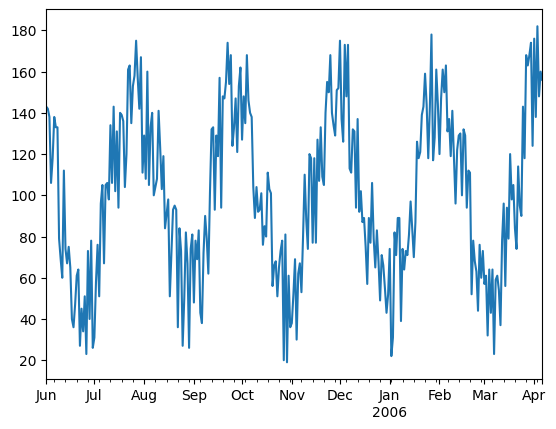

In [6]:
bikes['Berri 1'].plot()

Next up, we're just going to look at the Berri bike path. Berri is a street in Montreal, with a pretty important bike path. I use it mostly on my way to the library now, but I used to take it to work sometimes when I worked in Old Montreal.

So we're going to create a dataframe with just the Berri bikepath in it

In [7]:
berri_bikes = bikes[['Berri 1']].copy()

In [8]:
berri_bikes[:5]

,Berri 1
2005-06-01,143
2005-06-02,142
2005-06-03,138
2005-06-04,106
2005-06-05,118


Next, we need to add a 'weekday' column. Firstly, we can get the weekday from the index. We haven't talked about indexes yet, but the index is what's on the left on the above dataframe, under 'Date'. It's basically all the days of the year.

In [9]:
berri_bikes.index

DatetimeIndex(['2005-06-01', '2005-06-02', '2005-06-03', '2005-06-04',
               '2005-06-05', '2005-06-06', '2005-06-07', '2005-06-08',
               '2005-06-09', '2005-06-10',
               ...
               '2006-03-28', '2006-03-29', '2006-03-30', '2006-03-31',
               '2006-04-01', '2006-04-02', '2006-04-03', '2006-04-04',
               '2006-04-05', '2006-04-06'],
              dtype='datetime64[ns]', length=310, freq=None)

You can see that actually some of the days are missing -- only 310 days of the year are actually there. Who knows why.

Pandas has a bunch of really great time series functionality, so if we wanted to get the day of the month for each row, we could do it like this:

In [10]:
berri_bikes.index.day

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            28, 29, 30, 31,  1,  2,  3,  4,  5,  6],
           dtype='int64', length=310)

We actually want the weekday, though:

In [11]:
berri_bikes.index.weekday

Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
            ...
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3],
           dtype='int64', length=310)

These are the days of the week, where 0 is Monday. I found out that 0 was Monday by checking on a calendar.

Now that we know how to get the weekday, we can add it as a column in our dataframe like this:

In [12]:
berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
berri_bikes[:5]

,Berri 1,weekday
2005-06-01,143,2
2005-06-02,142,3
2005-06-03,138,4
2005-06-04,106,5
2005-06-05,118,6


## Adding up the cyclists by weekday

This turns out to be really easy!

Dataframes have a `.groupby()` method that is similar to SQL groupby, if you're familiar with that. I'm not going to explain more about it right now -- if you want to to know more, the [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) is really good.

In this case, `berri_bikes.groupby('weekday').aggregate(sum)` means "Group the rows by weekday and then add up all the values with the same weekday".

In [13]:
weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
weekday_counts

,Berri 1
weekday,
0,4414
1,4439
2,4749
3,4499
4,4388
5,4402
6,4278


It's hard to remember what 0, 1, 2, 3, 4, 5, 6 mean, so we can fix it up and graph it:

In [14]:
# weekday_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# weekday_counts

<AxesSubplot: xlabel='weekday'>

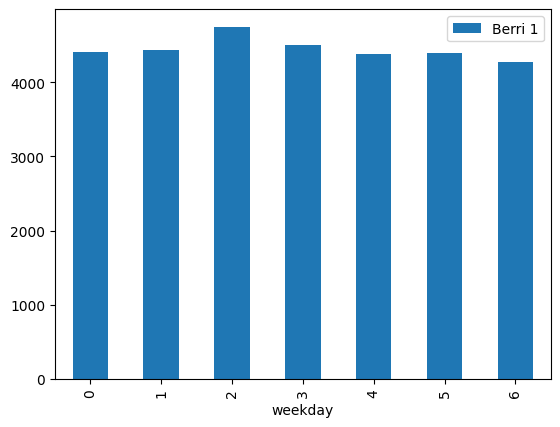

In [15]:
weekday_counts.plot(kind='bar')

So it looks like Montrealers are commuter cyclists -- they bike much more during the week. Neat!

## Putting it together

Now we want to request the full code execution.

Let's put all that together, to prove how easy it is. 6 lines of magical pandas!

If you want to play around, try changing sum to max, numpy.median, or any other function you like.

In [16]:
# Todo, fix indexes in function

In [17]:
@sy.syft_function(input_policy=sy.ExactMatch(bikes=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_bike_hist(bikes):
    berri_bikes = bikes[['Berri 1']].copy()
    berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
    weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
    return weekday_counts

Request code execution

In [18]:
req = guest_domain_client.api.services.code.request_code_execution(get_bike_hist)

In [19]:
submitted_code = guest_domain_client.code[0]

In [20]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [21]:
new_project = sy.Project(name="Pandas Chapter 4",
                         description="Hi, I would like to plot histogram of bikers per weekday")

In [22]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [23]:
guest_domain_client.submit_project(new_project)

<class 'syft.core.node.new.response.SyftSuccess'>: Project Submitted